In [42]:
# CELL 1: Install Required Libraries
!pip install -q torch torchvision opencv-python-headless pillow matplotlib seaborn scikit-learn tqdm onnx
!pip install onnx onnxscript

In [43]:
# CELL 2: Import Libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, models
from torchvision.datasets import ImageFolder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_recall_fscore_support
import cv2
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

print("✓ All libraries imported successfully!")
print(f"✓ PyTorch version: {torch.__version__}")
print(f"✓ CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"✓ GPU: {torch.cuda.get_device_name(0)}")


✓ All libraries imported successfully!
✓ PyTorch version: 2.9.0+cpu
✓ CUDA available: False


In [44]:
# CELL 3 + CELL 4: Upload, Extract, Auto-Clean, Configuration
from google.colab import files
import zipfile
import os
import shutil
import torch
import numpy as np
# Upload dataset zip
print("Upload your Cleaned Data Set.zip...\n")
uploaded = files.upload()

# Extract uploaded zip
for filename in uploaded.keys():
    print(f"\n Extracting {filename}...")
    with zipfile.ZipFile(filename, 'r') as zip_ref:
        zip_ref.extractall('dataset_temp')
    print("✓ Extraction complete!")

# Detect folder containing Train/Validation/Test
final_dataset_path = None
for root, dirs, files in os.walk('dataset_temp'):
    if all(x in dirs for x in ['Train', 'Validation', 'Test']):
        final_dataset_path = root
        break
if final_dataset_path is None:
    raise FileNotFoundError("Could not find Train/Validation/Test folders inside the zip!")

# Move to 'dataset/' for consistency
if os.path.exists('dataset'):
    shutil.rmtree('dataset')
shutil.move(final_dataset_path, 'dataset')

# Optional cleanup: remove empty folders inside splits
for split in ['Train','Validation','Test']:
    split_path = os.path.join('dataset', split)
    for folder in os.listdir(split_path):
        folder_path = os.path.join(split_path, folder)
        if os.path.isdir(folder_path):
            images = [f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg','.jpeg','.png'))]
            if len(images) == 0:
                shutil.rmtree(folder_path)

#  Final verification
print("\n Final dataset structure:")
for split in ['Train','Validation','Test']:
    split_path = os.path.join('dataset', split)
    if os.path.exists(split_path):
        classes = [d for d in os.listdir(split_path) if os.path.isdir(os.path.join(split_path,d))]
        print(f"{split}/ - {len(classes)} classes: {classes}")
    else:
        print(f"{split}/ NOT FOUND")

# Configuration Cell (replaces Cell 4)
class Config:
    # Dataset path
    DATA_DIR = "dataset"

    # Class names - EXACT folder names from your dataset
    CLASSES = [
        'Bridge', 'Clean', 'CMP', 'Crackes', 'LER',
        'Missing patterns', 'Multiple defects in one image',
        'Open', 'Ripple', 'Scratch',
        'Stain and Edge Contamination', 'VIAS'
    ]

    # Training parameters
    BATCH_SIZE = 32
    LEARNING_RATE = 0.001
    NUM_EPOCHS = 10
    IMG_SIZE = 224

    # Model paths
    MODEL_PATH = "sem_mobilenetv2_model.pth"
    ONNX_PATH = "sem_mobilenetv2_model.onnx"

    # Patch settings for Stage 2
    GRID_SIZE = 3  # 3×3 = 9 patches

    # Device
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Random seed
    SEED = 42

# Set random seeds
torch.manual_seed(Config.SEED)
np.random.seed(Config.SEED)

# Display configuration
print("\n" + "="*70)
print("CONFIGURATION")
print("="*70)
print(f"Device: {Config.DEVICE}")
print(f"Number of classes: {len(Config.CLASSES)}")
print(f"Batch size: {Config.BATCH_SIZE}")
print(f"Epochs: {Config.NUM_EPOCHS}")
print(f"Image size: {Config.IMG_SIZE}×{Config.IMG_SIZE}")
print(f"Grid size: {Config.GRID_SIZE}×{Config.GRID_SIZE} = {Config.GRID_SIZE**2} patches")
print("="*70)

print("\n Dataset is ready! You can now run your dataset loading cell safely:")
print(f"train_dataset, val_dataset, test_dataset, class_counts = load_datasets_from_folders(Config.DATA_DIR)")



Upload your Cleaned Data Set.zip...



Saving CleanedDataset.zip to CleanedDataset (1).zip

 Extracting CleanedDataset (1).zip...
✓ Extraction complete!

 Final dataset structure:
Train/ - 12 classes: ['Open', 'VIAS', 'Clean', 'Missing patterns', 'Multiple defects in one image', 'LER', 'Stain and Edge Contamination', 'CMP', 'Scratch', 'Ripple', 'Crackes', 'Bridge']
Validation/ - 12 classes: ['Open', 'VIAS', 'Clean', 'Missing patterns', 'Multiple defects in one image', 'LER', 'Stain and Edge Contamination', 'CMP', 'Scratch', 'Ripple', 'Crackes', 'Bridge']
Test/ - 12 classes: ['Open', 'VIAS', 'Clean', 'Missing patterns', 'Multiple defects in one image', 'LER', 'Stain and Edge Contamination', 'CMP', 'Scratch', 'Ripple', 'Crackes', 'Bridge']

CONFIGURATION
Device: cpu
Number of classes: 12
Batch size: 32
Epochs: 10
Image size: 224×224
Grid size: 3×3 = 9 patches

 Dataset is ready! You can now run your dataset loading cell safely:
train_dataset, val_dataset, test_dataset, class_counts = load_datasets_from_folders(Config.DATA_DIR

In [45]:
# CELL 5: Data Transforms (NO ColorJitter)
def get_transforms(train=True):
    """Get data transforms - NO ColorJitter as requested"""
    if train:
        return transforms.Compose([
            transforms.Resize((Config.IMG_SIZE, Config.IMG_SIZE)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.RandomRotation(15),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    else:
        return transforms.Compose([
            transforms.Resize((Config.IMG_SIZE, Config.IMG_SIZE)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

print("✓ Data transforms defined (NO ColorJitter)")


✓ Data transforms defined (NO ColorJitter)


In [46]:
# CELL 6: Load Datasets with ImageFolder
def load_datasets_from_folders(data_dir):
    """Load datasets using ImageFolder for Train/Val/Test splits"""
    train_dir = os.path.join(data_dir, 'Train')
    val_dir = os.path.join(data_dir, 'Validation')
    test_dir = os.path.join(data_dir, 'Test')

    # Check if folders exist
    for folder_name, folder_path in [('Train', train_dir), ('Validation', val_dir), ('Test', test_dir)]:
        if not os.path.exists(folder_path):
            raise FileNotFoundError(f"{folder_name} folder not found at: {folder_path}")

    print(f"\n{'='*70}")
    print(f"LOADING DATASETS FROM: {data_dir}")
    print(f"{'='*70}\n")

    # Load datasets using ImageFolder
    train_dataset = ImageFolder(train_dir, transform=get_transforms(train=True))
    val_dataset = ImageFolder(val_dir, transform=get_transforms(train=False))
    test_dataset = ImageFolder(test_dir, transform=get_transforms(train=False))

    # Print class distribution for training set
    print("Training set class distribution:")
    class_counts = {}
    for _, label in train_dataset.samples:
        class_name = train_dataset.classes[label]
        class_counts[class_name] = class_counts.get(class_name, 0) + 1

    for class_name in train_dataset.classes:
        count = class_counts.get(class_name, 0)
        print(f"  {class_name:35s}: {count:4d} images")

    print(f"\nDataset sizes:")
    print(f"  Training:   {len(train_dataset):5d} images")
    print(f"  Validation: {len(val_dataset):5d} images")
    print(f"  Testing:    {len(test_dataset):5d} images")
    print(f"\n{'='*70}\n")

    return train_dataset, val_dataset, test_dataset, class_counts


def compute_class_weights(class_counts, class_names):
    """Compute class weights for weighted loss (handles imbalanced datasets)"""
    # Get counts in the order of class indices
    counts = [class_counts.get(class_name, 0) for class_name in class_names]
    total = sum(counts)

    # Compute weights (inverse frequency)
    weights = [total / (len(counts) * count) if count > 0 else 0 for count in counts]

    print("Class weights for weighted CrossEntropyLoss:")
    for class_name, weight in zip(class_names, weights):
        print(f"  {class_name:35s}: {weight:.4f}")
    print()

    return torch.FloatTensor(weights)


# Load the datasets
train_dataset, val_dataset, test_dataset, class_counts = load_datasets_from_folders(Config.DATA_DIR)

# Compute class weights
class_weights = compute_class_weights(class_counts, train_dataset.classes)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=Config.BATCH_SIZE,
                         shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=Config.BATCH_SIZE,
                       shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=Config.BATCH_SIZE,
                        shuffle=False, num_workers=2, pin_memory=True)

print("✓ Dataloaders created successfully!")



LOADING DATASETS FROM: dataset

Training set class distribution:
  Bridge                             :  147 images
  CMP                                :  117 images
  Clean                              :   58 images
  Crackes                            :  107 images
  LER                                :   62 images
  Missing patterns                   :   29 images
  Multiple defects in one image      :   29 images
  Open                               :   93 images
  Ripple                             :   63 images
  Scratch                            :  127 images
  Stain and Edge Contamination       :   19 images
  VIAS                               :   14 images

Dataset sizes:
  Training:     865 images
  Validation:   183 images
  Testing:      198 images


Class weights for weighted CrossEntropyLoss:
  Bridge                             : 0.4904
  CMP                                : 0.6161
  Clean                              : 1.2428
  Crackes                            : 0

In [47]:
# CELL 7: Create MobileNetV2 Model
def create_model(num_classes):
    """Create MobileNetV2 model with transfer learning"""
    print("\nCreating MobileNetV2 model...")
    model = models.mobilenet_v2(pretrained=True)

    # Freeze early layers for faster training
    for param in model.features[:10].parameters():
        param.requires_grad = False

    # Replace classifier for our classes
    model.classifier = nn.Sequential(
        nn.Dropout(0.2),
        nn.Linear(model.last_channel, num_classes)
    )

    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"✓ Total parameters: {total_params:,}")
    print(f"✓ Trainable parameters: {trainable_params:,}")

    return model

# Create model
model = create_model(num_classes=len(Config.CLASSES))
model = model.to(Config.DEVICE)
print(f"✓ Model moved to {Config.DEVICE}")



Creating MobileNetV2 model...
✓ Total parameters: 2,239,244
✓ Trainable parameters: 2,054,156
✓ Model moved to cpu


In [48]:
# CELL 8: Train the Model
def train_model(model, train_loader, val_loader, num_epochs, device, class_weights):
    """Train the model with weighted loss and progress tracking"""
    # Use weighted CrossEntropyLoss for class imbalance
    criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),
                          lr=Config.LEARNING_RATE)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3)

    best_val_acc = 0.0
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    print(f"\n{'='*70}")
    print(f"STARTING TRAINING FOR {num_epochs} EPOCHS")
    print(f"{'='*70}\n")

    for epoch in range(num_epochs):
        # ===== TRAINING PHASE =====
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            pbar.set_postfix({
                'loss': f'{running_loss/len(pbar):.4f}',
                'acc': f'{100.*correct/total:.2f}%'
            })

        train_loss = running_loss / len(train_loader)
        train_acc = 100. * correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # ===== VALIDATION PHASE =====
        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                running_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        val_loss = running_loss / len(val_loader)
        val_acc = 100. * correct / total
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        scheduler.step(val_loss)

        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'  Train - Loss: {train_loss:.4f}, Acc: {train_acc:.2f}%')
        print(f'  Val   - Loss: {val_loss:.4f}, Acc: {val_acc:.2f}%')

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), Config.MODEL_PATH)
            print(f'  ✓ Best model saved (Val Acc: {val_acc:.2f}%)')
        print()

    print(f"{'='*70}")
    print(f"TRAINING COMPLETE! Best validation accuracy: {best_val_acc:.2f}%")
    print(f"{'='*70}\n")

    return train_losses, val_losses, train_accs, val_accs


# Train the model
train_losses, val_losses, train_accs, val_accs = train_model(
    model, train_loader, val_loader, Config.NUM_EPOCHS, Config.DEVICE, class_weights
)



STARTING TRAINING FOR 10 EPOCHS



Epoch 1/10 [Train]: 100%|██████████| 28/28 [01:34<00:00,  3.39s/it, loss=1.0170, acc=67.40%]


Epoch 1/10:
  Train - Loss: 1.0170, Acc: 67.40%
  Val   - Loss: 1.5524, Acc: 67.21%
  ✓ Best model saved (Val Acc: 67.21%)



Epoch 2/10 [Train]: 100%|██████████| 28/28 [01:33<00:00,  3.33s/it, loss=0.6081, acc=82.66%]


Epoch 2/10:
  Train - Loss: 0.6081, Acc: 82.66%
  Val   - Loss: 0.6677, Acc: 81.42%
  ✓ Best model saved (Val Acc: 81.42%)



Epoch 3/10 [Train]: 100%|██████████| 28/28 [01:32<00:00,  3.32s/it, loss=0.3357, acc=91.21%]


Epoch 3/10:
  Train - Loss: 0.3357, Acc: 91.21%
  Val   - Loss: 0.5129, Acc: 81.97%
  ✓ Best model saved (Val Acc: 81.97%)



Epoch 4/10 [Train]: 100%|██████████| 28/28 [01:35<00:00,  3.39s/it, loss=0.4054, acc=89.48%]


Epoch 4/10:
  Train - Loss: 0.4054, Acc: 89.48%
  Val   - Loss: 0.6072, Acc: 89.62%
  ✓ Best model saved (Val Acc: 89.62%)



Epoch 5/10 [Train]: 100%|██████████| 28/28 [01:34<00:00,  3.37s/it, loss=0.2577, acc=92.14%]


Epoch 5/10:
  Train - Loss: 0.2577, Acc: 92.14%
  Val   - Loss: 0.7694, Acc: 86.89%



Epoch 6/10 [Train]: 100%|██████████| 28/28 [01:35<00:00,  3.40s/it, loss=0.3343, acc=93.64%]


Epoch 6/10:
  Train - Loss: 0.3343, Acc: 93.64%
  Val   - Loss: 0.1765, Acc: 93.44%
  ✓ Best model saved (Val Acc: 93.44%)



Epoch 7/10 [Train]: 100%|██████████| 28/28 [01:36<00:00,  3.43s/it, loss=0.3594, acc=96.07%]


Epoch 7/10:
  Train - Loss: 0.3594, Acc: 96.07%
  Val   - Loss: 0.0639, Acc: 98.91%
  ✓ Best model saved (Val Acc: 98.91%)



Epoch 8/10 [Train]: 100%|██████████| 28/28 [01:33<00:00,  3.35s/it, loss=0.2029, acc=96.99%]


Epoch 8/10:
  Train - Loss: 0.2029, Acc: 96.99%
  Val   - Loss: 0.1616, Acc: 95.63%



Epoch 9/10 [Train]: 100%|██████████| 28/28 [01:47<00:00,  3.83s/it, loss=0.3864, acc=93.76%]


Epoch 9/10:
  Train - Loss: 0.3864, Acc: 93.76%
  Val   - Loss: 0.1583, Acc: 96.72%



Epoch 10/10 [Train]: 100%|██████████| 28/28 [01:33<00:00,  3.34s/it, loss=0.4184, acc=90.64%]


Epoch 10/10:
  Train - Loss: 0.4184, Acc: 90.64%
  Val   - Loss: 0.2455, Acc: 91.80%

TRAINING COMPLETE! Best validation accuracy: 98.91%



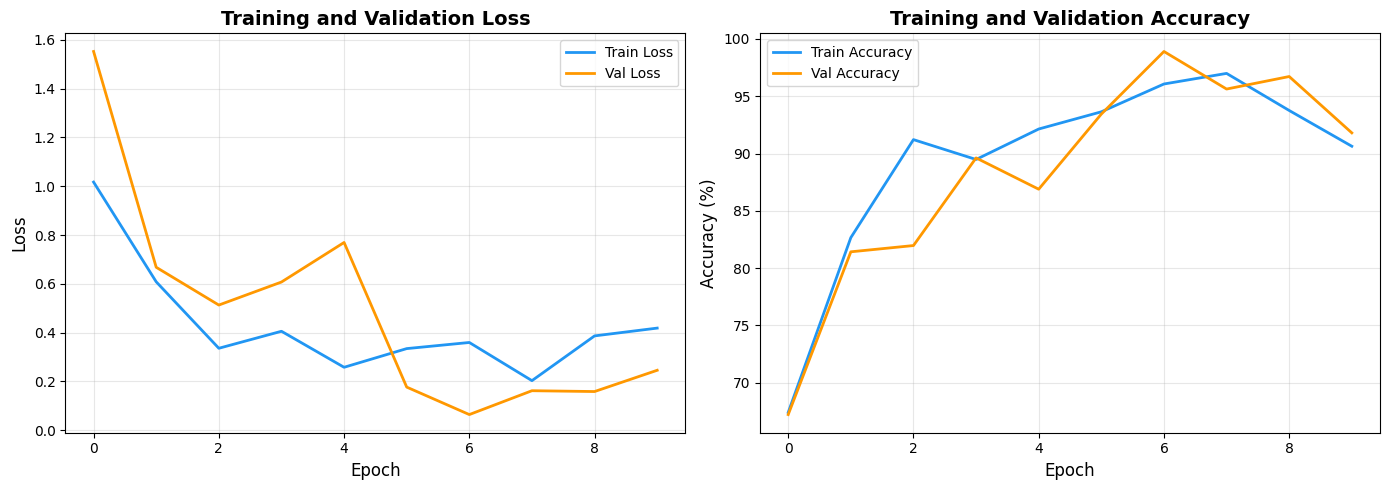

✓ Training history saved: training_history.png


In [49]:
# CELL 9: Plot Training History
def plot_training_history(train_losses, val_losses, train_accs, val_accs):
    """Plot training history curves"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Loss plot
    ax1.plot(train_losses, label='Train Loss', linewidth=2, color='#2196F3')
    ax1.plot(val_losses, label='Val Loss', linewidth=2, color='#FF9800')
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Accuracy plot
    ax2.plot(train_accs, label='Train Accuracy', linewidth=2, color='#2196F3')
    ax2.plot(val_accs, label='Val Accuracy', linewidth=2, color='#FF9800')
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Accuracy (%)', fontsize=12)
    ax2.set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("✓ Training history saved: training_history.png")

plot_training_history(train_losses, val_losses, train_accs, val_accs)

✓ Best model loaded from: sem_mobilenetv2_model.pth

EVALUATING MODEL ON TEST SET



Testing: 100%|██████████| 7/7 [00:11<00:00,  1.68s/it]



MODEL EVALUATION RESULTS
Accuracy:  95.45%
Precision: 95.93%
Recall:    95.45%
F1 Score:  95.11%
Platform:  PyTorch 2.9.0+cpu
Model Size: 8.78 MB



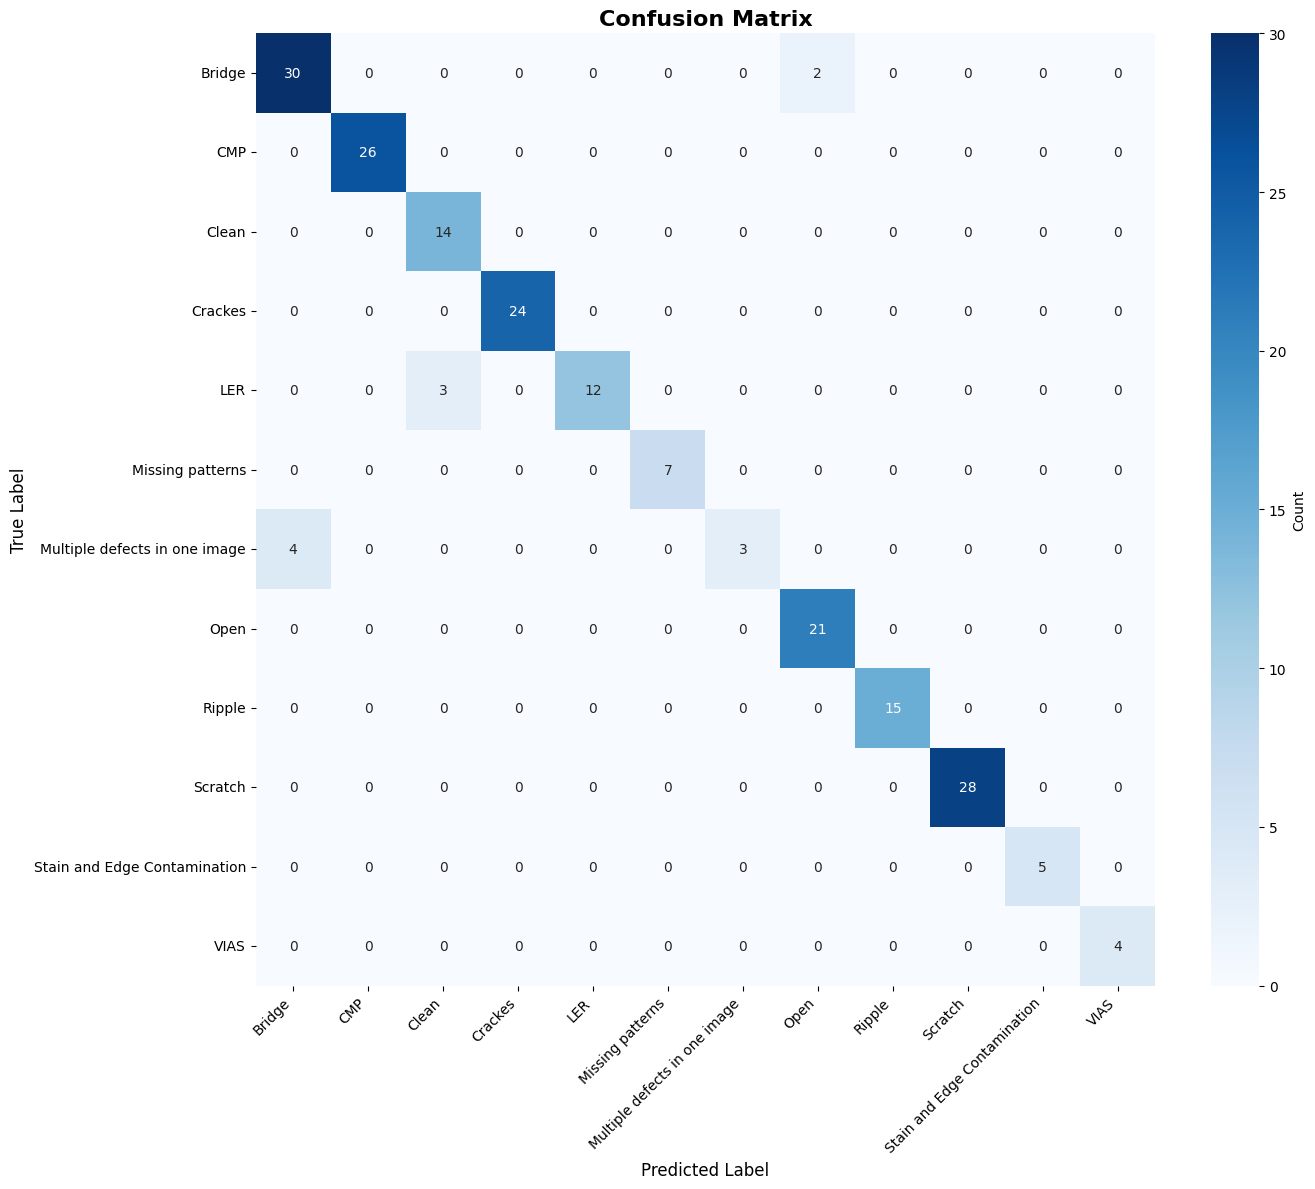

✓ Confusion matrix saved: confusion_matrix.png

Detailed Classification Report:
                               precision    recall  f1-score   support

                       Bridge      0.882     0.938     0.909        32
                          CMP      1.000     1.000     1.000        26
                        Clean      0.824     1.000     0.903        14
                      Crackes      1.000     1.000     1.000        24
                          LER      1.000     0.800     0.889        15
             Missing patterns      1.000     1.000     1.000         7
Multiple defects in one image      1.000     0.429     0.600         7
                         Open      0.913     1.000     0.955        21
                       Ripple      1.000     1.000     1.000        15
                      Scratch      1.000     1.000     1.000        28
 Stain and Edge Contamination      1.000     1.000     1.000         5
                         VIAS      1.000     1.000     1.000       

In [50]:
# CELL 10: Evaluate Model on Test Set
def evaluate_model(model, test_loader, device, classes):
    """Comprehensive model evaluation with metrics"""
    print(f"\n{'='*70}")
    print("EVALUATING MODEL ON TEST SET")
    print(f"{'='*70}\n")

    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc='Testing'):
            images = images.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='weighted', zero_division=0
    )

    print(f"\n{'='*70}")
    print("MODEL EVALUATION RESULTS")
    print(f"{'='*70}")
    print(f"Accuracy:  {accuracy*100:.2f}%")
    print(f"Precision: {precision*100:.2f}%")
    print(f"Recall:    {recall*100:.2f}%")
    print(f"F1 Score:  {f1*100:.2f}%")
    print(f"Platform:  PyTorch {torch.__version__}")

    # Model size
    if os.path.exists(Config.MODEL_PATH):
        model_size = os.path.getsize(Config.MODEL_PATH) / (1024 * 1024)
        print(f"Model Size: {model_size:.2f} MB")
    print(f"{'='*70}\n")

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    plt.figure(figsize=(14, 12))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes, cbar_kws={'label': 'Count'})
    plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("✓ Confusion matrix saved: confusion_matrix.png")

    # Classification report
    report = classification_report(all_labels, all_preds, target_names=classes, digits=3, zero_division=0)
    print("\nDetailed Classification Report:")
    print(report)

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix': cm.tolist()
    }

# Load best model and evaluate
model.load_state_dict(torch.load(Config.MODEL_PATH))
print(f"✓ Best model loaded from: {Config.MODEL_PATH}")

metrics = evaluate_model(model, test_loader, Config.DEVICE, train_dataset.classes)


In [51]:
# CELL 11: Export to ONNX (One Line!)
def export_to_onnx(model, device):
    """Export trained model to ONNX format"""
    print("\nExporting model to ONNX format...")
    model.eval()
    dummy_input = torch.randn(1, 3, Config.IMG_SIZE, Config.IMG_SIZE).to(device)

    torch.onnx.export(
        model,
        dummy_input,
        Config.ONNX_PATH,
        export_params=True,
        opset_version=11,
        do_constant_folding=True,
        input_names=['input'],
        output_names=['output'],
        dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}}
    )

    onnx_size = os.path.getsize(Config.ONNX_PATH) / (1024 * 1024)
    print(f"✓ ONNX model exported: {Config.ONNX_PATH}")
    print(f"  Size: {onnx_size:.2f} MB\n")

export_to_onnx(model, Config.DEVICE)

W0207 15:07:58.704000 1931 torch/onnx/_internal/exporter/_compat.py:114] Setting ONNX exporter to use operator set version 18 because the requested opset_version 11 is a lower version than we have implementations for. Automatic version conversion will be performed, which may not be successful at converting to the requested version. If version conversion is unsuccessful, the opset version of the exported model will be kept at 18. Please consider setting opset_version >=18 to leverage latest ONNX features



Exporting model to ONNX format...


W0207 15:07:59.924000 1931 torch/onnx/_internal/exporter/_schemas.py:455] Missing annotation for parameter 'input' from (input, boxes, output_size: 'Sequence[int]', spatial_scale: 'float' = 1.0, sampling_ratio: 'int' = -1, aligned: 'bool' = False). Treating as an Input.
W0207 15:07:59.926000 1931 torch/onnx/_internal/exporter/_schemas.py:455] Missing annotation for parameter 'boxes' from (input, boxes, output_size: 'Sequence[int]', spatial_scale: 'float' = 1.0, sampling_ratio: 'int' = -1, aligned: 'bool' = False). Treating as an Input.
W0207 15:07:59.929000 1931 torch/onnx/_internal/exporter/_schemas.py:455] Missing annotation for parameter 'input' from (input, boxes, output_size: 'Sequence[int]', spatial_scale: 'float' = 1.0). Treating as an Input.
W0207 15:07:59.931000 1931 torch/onnx/_internal/exporter/_schemas.py:455] Missing annotation for parameter 'boxes' from (input, boxes, output_size: 'Sequence[int]', spatial_scale: 'float' = 1.0). Treating as an Input.


[torch.onnx] Obtain model graph for `MobileNetV2([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `MobileNetV2([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...
[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...


Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/onnxscript/version_converter/__init__.py", line 127, in call
    converted_proto = _c_api_utils.call_onnx_api(
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/onnxscript/version_converter/_c_api_utils.py", line 65, in call_onnx_api
    result = func(proto)
             ^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/onnxscript/version_converter/__init__.py", line 122, in _partial_convert_version
    return onnx.version_converter.convert_version(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/onnx/version_converter.py", line 39, in convert_version
    converted_model_str = C.convert_version(model_str, target_version)
                          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: /github/workspace/onnx/version_converter/adapters/axes_input_to_attribute.h:65: adapt: Asserti

[torch.onnx] Translate the graph into ONNX... ✅
Applied 104 of general pattern rewrite rules.
✓ ONNX model exported: sem_mobilenetv2_model.onnx
  Size: 0.24 MB



In [62]:
# CELL 12 : STABLE 4-STAGE INSPECTION PIPELINE
DEFECT_CONF_THRESH = 0.60  # conservative

# ---------- Stage 1 ----------
def stage1_classify_image(model, image_path, transform, device, classes):

    image = Image.open(image_path).convert("RGB")
    tensor = transform(image).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        out = model(tensor)
        prob = torch.softmax(out, dim=1)
        conf, pred = prob.max(1)

    return classes[pred.item()], conf.item()


# ---------- Stage 2 ----------
def stage2_patch_analysis(model, image_path, transform, device, classes, grid=3):

    image = Image.open(image_path).convert("RGB")
    W, H = image.size

    pw, ph = W // grid, H // grid

    patches = []
    preds = []
    confs = []

    model.eval()
    with torch.no_grad():
        for i in range(grid):
            for j in range(grid):

                patch = image.crop((j*pw, i*ph, (j+1)*pw, (i+1)*ph))
                patches.append(patch)

                t = transform(patch).unsqueeze(0).to(device)
                out = model(t)
                prob = torch.softmax(out, dim=1)
                conf, pred = prob.max(1)

                preds.append(classes[pred.item()])
                confs.append(conf.item())

    return patches, preds, confs, (H, W)



# ---------- Defect Rule ----------
def is_defective(pred, conf):
    if pred == "Clean":
        return False
    return conf >= DEFECT_CONF_THRESH


# ---------- Stage 3 ----------
def stage3_create_defect_map(image_path, patch_preds, patch_confs, grid=3):

    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    h, w = img.shape[:2]
    ph, pw = h//grid, w//grid

    overlay = img.copy()
    k = 0

    for i in range(grid):
        for j in range(grid):

            y1,y2 = i*ph,(i+1)*ph
            x1,x2 = j*pw,(j+1)*pw

            if is_defective(patch_preds[k], patch_confs[k]):
                cv2.rectangle(overlay,(x1,y1),(x2,y2),(255,0,0),-1)

            k+=1

    return cv2.addWeighted(img,0.75,overlay,0.25,0)


# ---------- Stage 4 ----------
def stage4_calculate_yield(preds, confs):

    clean = sum(1 for p in preds if p == "Clean")
    total = len(preds)

    yield_percent = round((clean / total) * 100, 1)

    return yield_percent, clean, total


# ---------- Fusion ----------
def fuse_stage1_with_patches(stage1_pred, patch_preds, patch_confs):

    defects = []

    for p,c in zip(patch_preds,patch_confs):
        if is_defective(p,c):
            defects.append(p)

    if len(defects)==0:
        return "Clean"

    return max(set(defects), key=defects.count)
print(" Stable inspection pipeline loaded")

 Stable inspection pipeline loaded


In [63]:
 # CELL 13 : DASHBOARD (WITH GRID + TABLE RESTORED)
import matplotlib.patches as patches

def create_inspection_dashboard(image_path, model, transform, device, classes, output_path):

    stage1_class, stage1_conf = stage1_classify_image(
        model, image_path, transform, device, classes)

    patches_img, patch_preds, patch_confs,_ = stage2_patch_analysis(
        model, image_path, transform, device, classes)

    final_stage1 = fuse_stage1_with_patches(
        stage1_class, patch_preds, patch_confs)

    defect_map = stage3_create_defect_map(
        image_path, patch_preds, patch_confs)

    yield_pct, clean_cnt, total_cnt = stage4_calculate_yield(
        patch_preds, patch_confs)

    fig = plt.figure(figsize=(22,14))
    gs = fig.add_gridspec(4,5)

    # ---------------- ORIGINAL ----------------
    ax1 = fig.add_subplot(gs[0,0:2])
    ax1.imshow(plt.imread(image_path))
    ax1.set_title("1. Original SEM Image")
    ax1.axis("off")

    # ---------------- DEFECT MAP ----------------
    ax2 = fig.add_subplot(gs[0,2:4])
    ax2.imshow(defect_map)
    ax2.set_title("3. Defect Localization Map")
    ax2.axis("off")

    # Draw yellow grid
    h, w,_ = defect_map.shape
    step_x = w//3
    step_y = h//3
    for i in range(1,3):
        ax2.axvline(i*step_x, color="yellow", linewidth=2)
        ax2.axhline(i*step_y, color="yellow", linewidth=2)

    # ---------------- STAGE 1 RESULT ----------------
    ax3 = fig.add_subplot(gs[0,4])
    ax3.text(0.5,0.6,final_stage1,
             ha="center",fontsize=16,fontweight="bold",
             color="red" if final_stage1!="Clean" else "green")
    ax3.text(0.5,0.4,f"Confidence: {stage1_conf*100:.1f}%")
    ax3.set_title("STAGE 1 RESULT")
    ax3.axis("off")

    # ---------------- PATCHES ----------------
    pos=[(1,0),(1,1),(1,2),(1,3),(1,4),
         (2,0),(2,1),(2,2),(2,3)]

    for i,(r,c) in enumerate(pos):
        ax = fig.add_subplot(gs[r,c])
        ax.imshow(patches_img[i])

        defective = is_defective(patch_preds[i], patch_confs[i])
        col = "red" if defective else "green"

        ax.set_title(
            f"Patch {i+1}: {patch_preds[i]}\n({patch_confs[i]*100:.1f}%)",
            fontsize=9,color=col,fontweight="bold")

        ax.axis("off")

    # ---------------- YIELD ----------------
    ax_y = fig.add_subplot(gs[3,0:2])
    ax_y.text(0.5,0.7,"STAGE 4: YIELD",ha="center",
              fontsize=14,fontweight="bold")
    ax_y.text(0.5,0.4,f"{yield_pct:.1f}%",
              ha="center",fontsize=40,fontweight="bold",
              color="green" if yield_pct>70 else "orange")
    ax_y.text(0.5,0.15,f"Clean patches: {clean_cnt}/{total_cnt}",
              ha="center",fontsize=12)
    ax_y.axis("off")

    # ---------------- SUMMARY TABLE ----------------
    ax_t = fig.add_subplot(gs[3,2:5])
    data=[
        ["Stage","Result","Details"],
        ["1. Classification",stage1_class,f"{stage1_conf*100:.1f}%"],
        ["2. Patch Analysis",f"{total_cnt} patches",
         f"{clean_cnt} clean, {total_cnt-clean_cnt} defect"],
        ["3. Defect Map","Generated","Red = defects"],
        ["4. Yield",f"{yield_pct:.1f}%",f"{clean_cnt}/{total_cnt}×100"]
    ]

    table = ax_t.table(cellText=data, loc="center", cellLoc="center")
    table.auto_set_font_size(False)
    table.set_fontsize(11)
    table.scale(1,1.5)
    ax_t.axis("off")

    plt.suptitle("SEM DEFECT INSPECTION DASHBOARD",fontsize=18,fontweight="bold")
    plt.savefig(output_path,dpi=300)
    plt.show()
    plt.close()

    print("Saved ->",output_path)


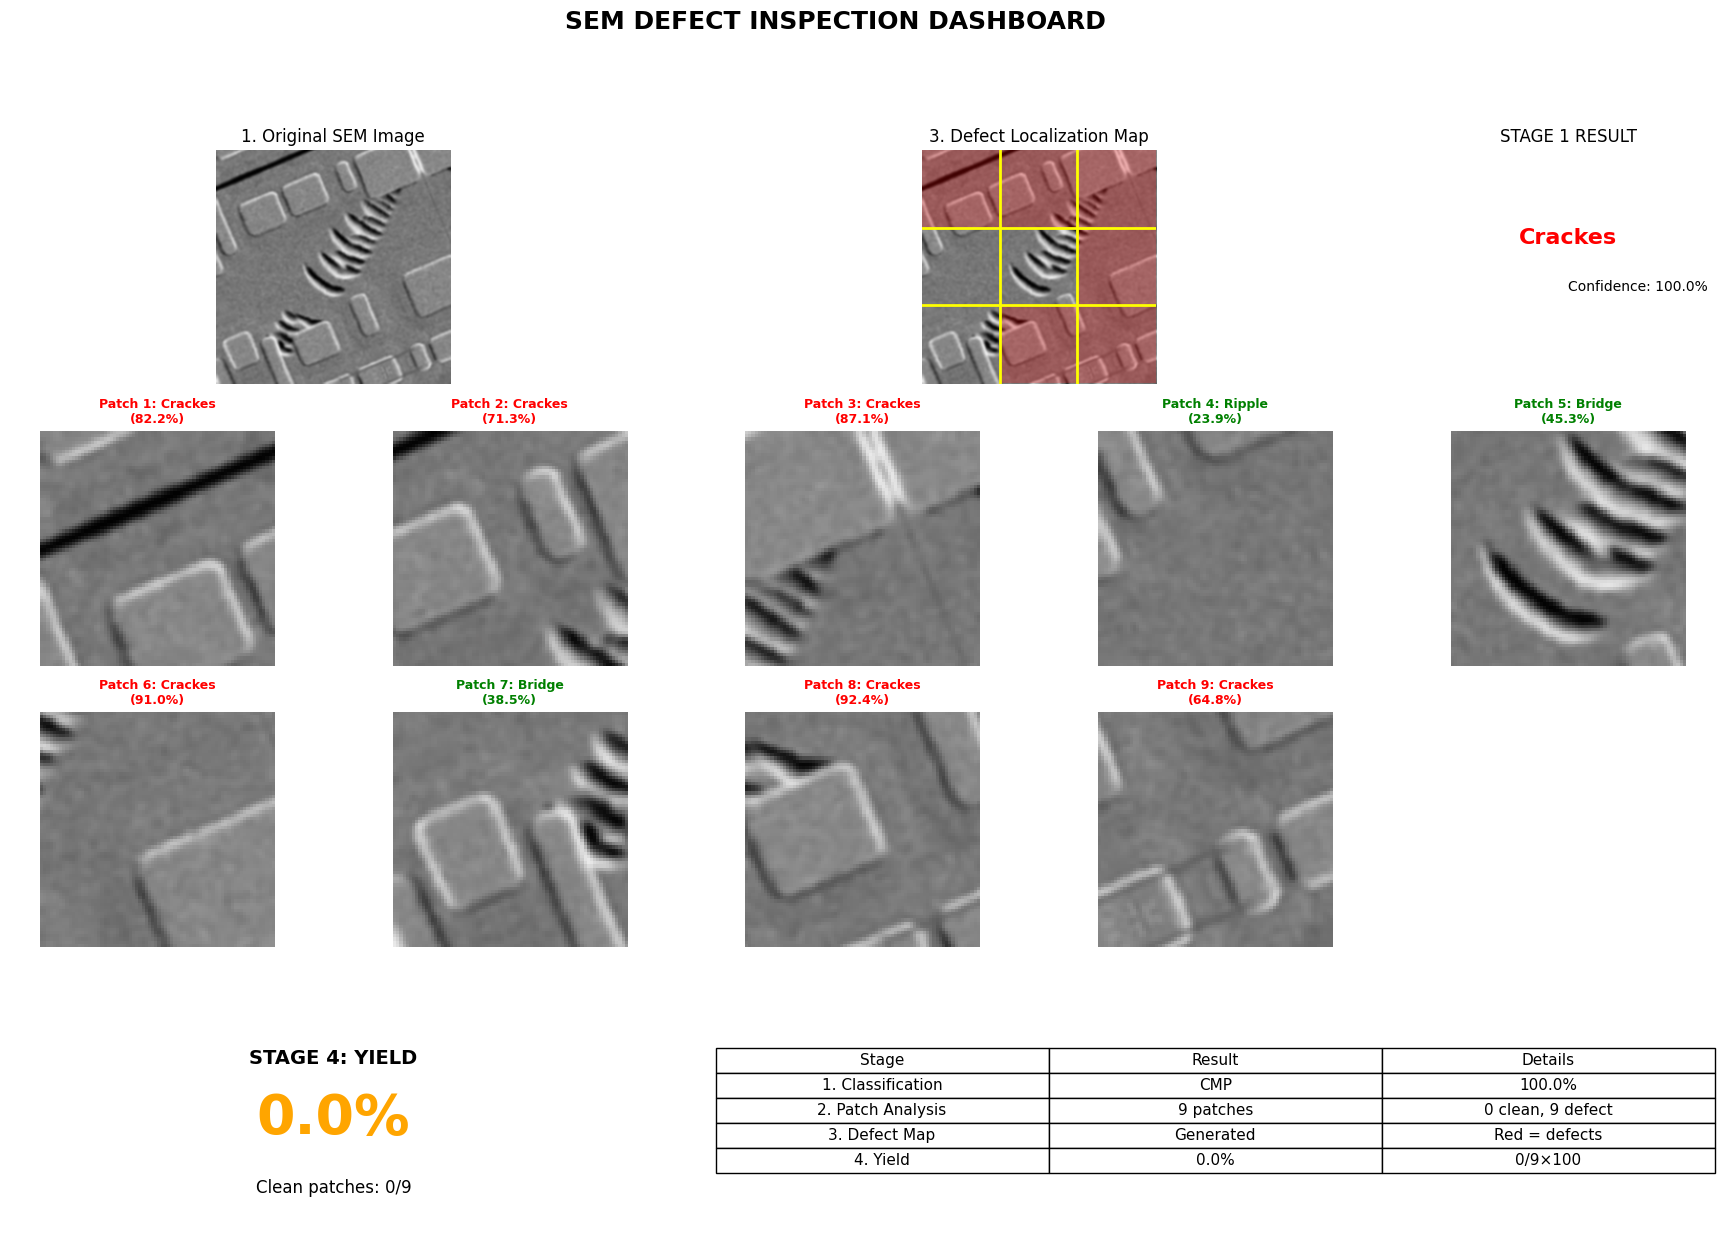

Saved -> inspection_result_1.png


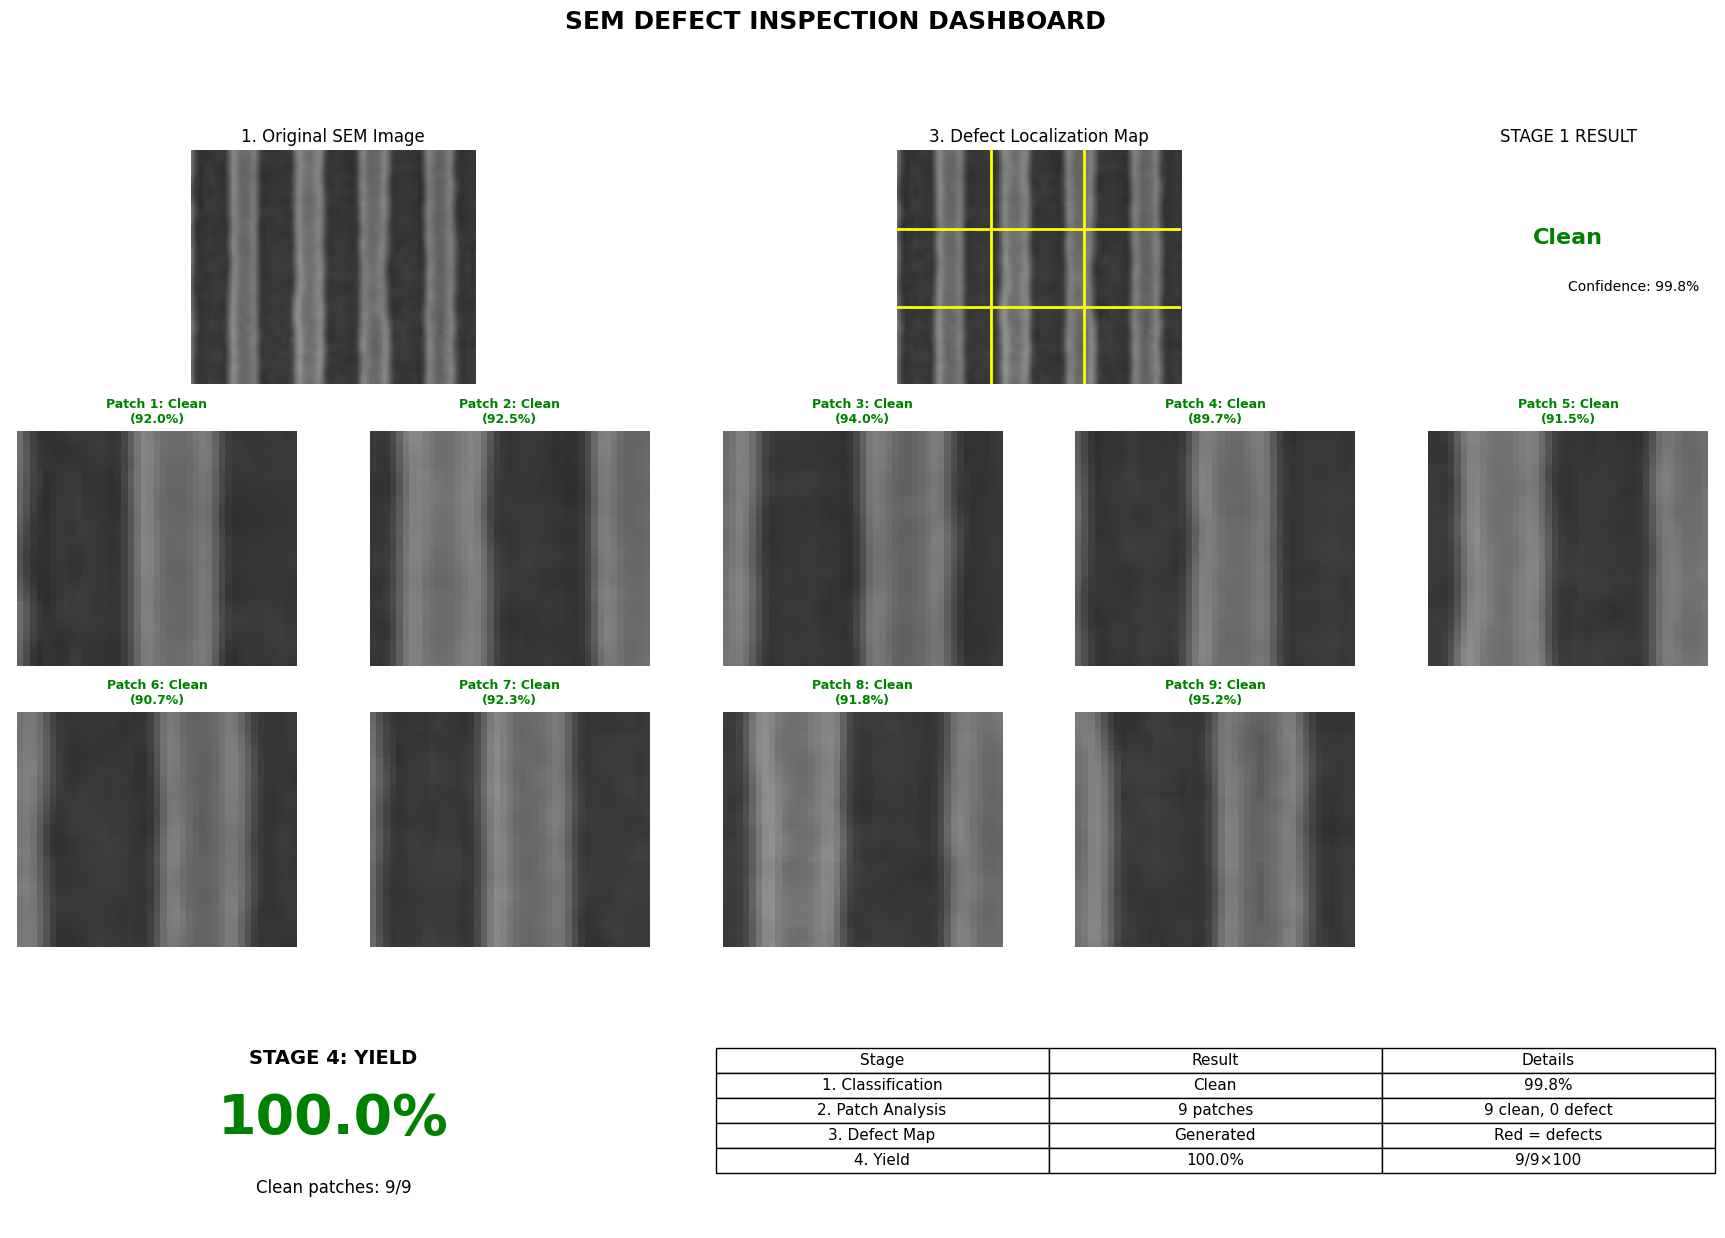

Saved -> inspection_result_2.png


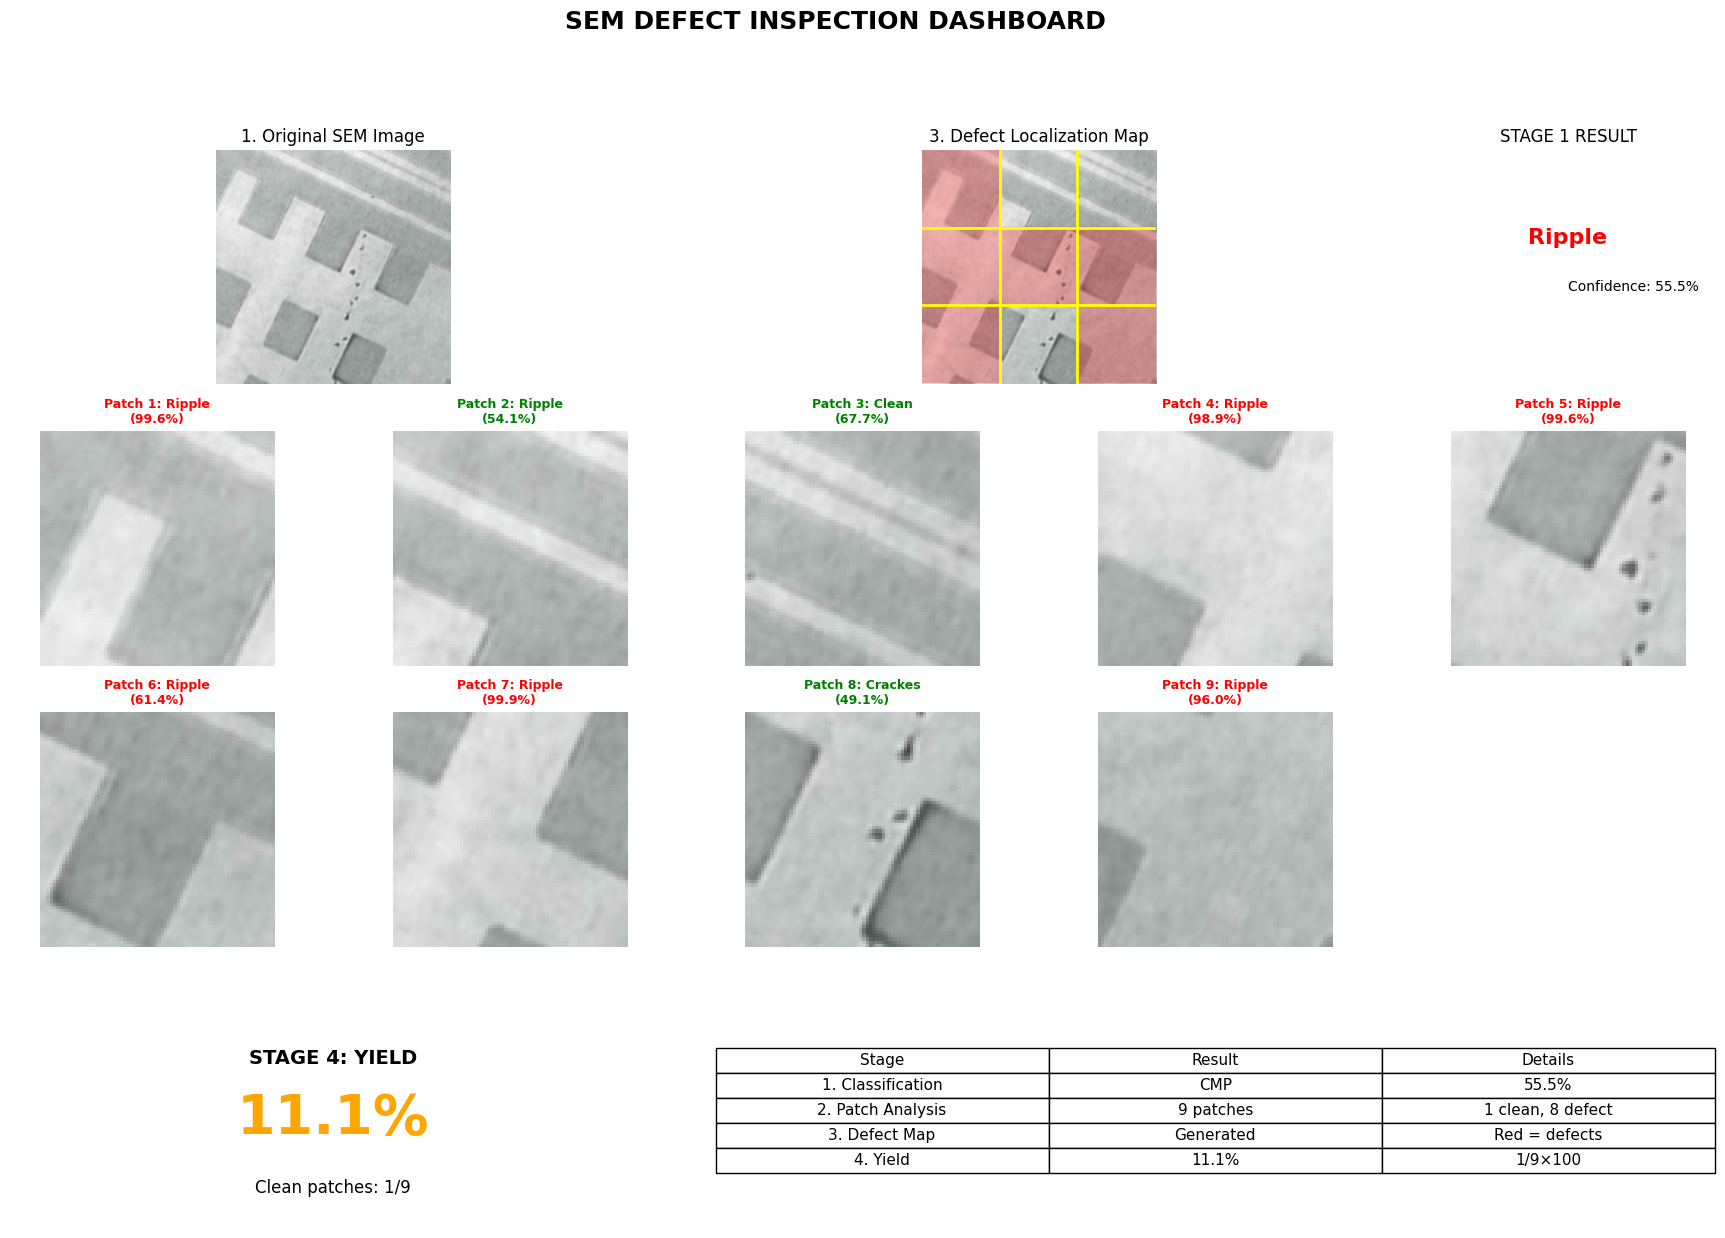

Saved -> inspection_result_3.png
ALL INSPECTIONS COMPLETE!


In [64]:
# CELL 14 : RUN ONLY 3 INSPECTIONS
import random

test_image_paths = [s[0] for s in test_dataset.samples]
sample_indices = random.sample(range(len(test_image_paths)),3)

for idx, sample_idx in enumerate(sample_indices):

    path = test_image_paths[sample_idx]
    out = f"inspection_result_{idx+1}.png"

    create_inspection_dashboard(
        path, model, get_transforms(False),
        Config.DEVICE, train_dataset.classes, out
    )

print("ALL INSPECTIONS COMPLETE!")

In [65]:
# CELL 15 : DOWNLOAD RESULTS (INSPECTIONS + METRICS + MODELS)

from google.colab import files
import zipfile
import os

with zipfile.ZipFile("inspection_results.zip","w") as z:

    # 3 inspection dashboards
    for i in range(3):
        f = f"inspection_result_{i+1}.png"
        if os.path.exists(f):
            z.write(f)

    # training curves
    if os.path.exists("training_history.png"):
        z.write("training_history.png")

    # confusion matrix
    if os.path.exists("confusion_matrix.png"):
        z.write("confusion_matrix.png")

    # FP32 ONNX model
    if os.path.exists(Config.ONNX_PATH):
        z.write(Config.ONNX_PATH)

    # INT8 ONNX model
    if os.path.exists("model_int8.onnx"):
        z.write("model_int8.onnx")

files.download("inspection_results.zip")
print("ZIP READY (dashboards + graphs + FP32 + INT8 ONNX)")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

ZIP READY (dashboards + graphs + FP32 + INT8 ONNX)
